In [46]:
import numpy as np
import os
import matlab.engine
import matplotlib.pyplot as plt
from Camera_util import parse_video, parse_mean_video
import pandas as pd
from natsort import natsorted
import time
import Camera_util 
import importlib
import pickle
import scipy.io
import heapq

In [ ]:
importlib.reload(Camera_util)
recordings_dir = '/Users/zacharykelly/Aguirre-Brainard Lab Dropbox/Zachary Kelly/FLIC_data/recordings'
experiment_filename = '200FPS'
light_levels = [str(i) for i in range(4)]
Camera_util.generate_TTF(recordings_dir, experiment_filename, light_levels)

In [ ]:

importlib.reload(Camera_util)
klein_dir = '/Users/zacharykelly/Aguirre-Brainard Lab Dropbox/Zachary Kelly/FLIC_data/klein'
videos = [ (file, scipy.io.loadmat(os.path.join(klein_dir, file))) for file in os.listdir(klein_dir)]


Analyzing 200FPS_6hz_0NDF.mat
Observed FPS: 256.001213110562
R2: 0.9977257946486847
Amplitude: 0.46951224759252164
Analyzing 200FPS_50hz_0NDF.mat
Observed FPS: 256.0009284384376
R2: 0.8509779163298518
Amplitude: 0.0601111787295925
Analyzing 200FPS_0.5hz_0NDF.mat
Observed FPS: 256.052412631902
R2: 0.999976574547079
Amplitude: 0.4892031944122274
Analyzing 200FPS_100hz_0NDF.mat
Observed FPS: 256.0148217034675
R2: 0.003971189071498371
Amplitude: 0.0028488358955671483
Analyzing 200FPS_3hz_0NDF.mat
Observed FPS: 256.0007764050038
R2: 0.9994203727402516
Amplitude: 0.4838360469475169
Analyzing 200FPS_1hz_0NDF.mat
Observed FPS: 256.0012933977345
R2: 0.9999055440092793
Amplitude: 0.489559800984846
Analyzing 200FPS_12hz_0NDF.mat
Observed FPS: 256.0000531691843
R2: 0.9910522911026672
Amplitude: 0.42285868644488406
Analyzing 200FPS_25hz_0NDF.mat
Observed FPS: 256.00004437680104
R2: 0.9616093110366747
Amplitude: 0.30835883441197615
Analyzing 200FPS_0.25hz_0NDF.mat
Observed FPS: 256.01297840416527
R2

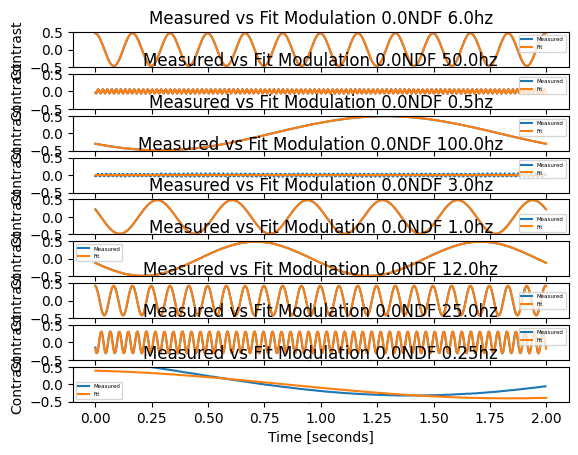

In [56]:
importlib.reload(Camera_util)
fig, axes = plt.subplots(len(videos),1)
results = {}
for ind, (filename, mat) in enumerate(videos):
    name, extension = os.path.splitext(filename)

    filename = name + f'_0NDF{extension}'

    print(f"Analyzing {filename}")

    file_info = Camera_util.parse_recording_filename(filename)

    light_level = file_info['NDF']
    f = file_info['frequency']
    video = mat['luminance256HzData'][0].flatten().astype(np.float64)

    observed_amplitude, observed_phase, observed_fps = Camera_util.fit_source_modulation(video, light_level, f, ax=axes[ind], fps_guess=256)

    results[f] = [observed_amplitude, observed_fps]

fig.show()

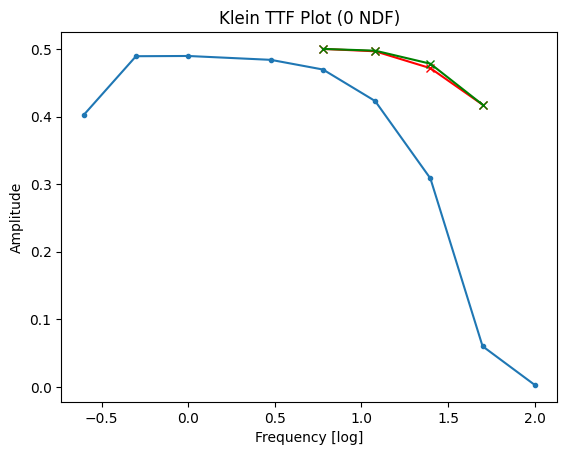

In [62]:
eng = matlab.engine.start_matlab() 
eng.addpath('/Users/zacharykelly/Documents/MATLAB/toolboxes/combiLEDToolbox/code/calibration/measureFlickerRolloff/')

# Sort the results by frequency
sorted_by_frequency = sorted(results.items())
frequencies = []
amplitudes = []

for (frequency, (amplitude, fps)) in sorted_by_frequency:
    frequencies.append(frequency)
    amplitudes.append(amplitude)

frequencies = np.array(frequencies, dtype=np.float64)
amplitudes = np.array(amplitudes)
expected_amplitudes = np.array(eng.contrastAttenuationByFreq(matlab.double([6,12,25,50]))).flatten()*0.5


plt.plot(np.log10(frequencies), amplitudes, marker='.')
plt.plot(np.log10([6,12,25,50]),[0.5,0.4965,0.4715,0.4175], marker='x', color='red')
plt.plot(np.log10([6,12,25,50]), expected_amplitudes, marker='o', color='green')
plt.xlabel('Frequency [log]')
plt.ylabel('Amplitude')
plt.title('Klein TTF Plot (0 NDF)')
plt.show()